In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

2025-02-16 02:56:33.243273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import re

In [3]:
# % Used Smartphone: LGE-lge-LG-H815-5.1                                             
# % Smartphone's Accelerometer: LGE Accelerometer - Vendor: BOSCH                    
# % --> Version: 1                                                                   
# % --> Min - Max Delay: 5000us - 65535000us                                         
# % --> Maximum Range: 16.000000263891405 G                                          
# % --> Resolution: 1.2136514986004396E-4 G                                          
                                                                                    
# % SensorTag's Accelerometer: MPU-9250 MEMS MotionTracking Device - Invensense      
# % --> Maximum Range: 16 G                                                          
# % --> Resolution: 0.00024 G                                                        
                                                                                    
# % MAC Address; Sensor_ID; Position; Device Model                                   
# %f8:95:c7:f3:ba:82; 0; RIGHTPOCKET; lge-LG-H815-5.1                                
# %C4:BE:84:70:64:8A; 1; CHEST; SensorTag                                            
# %C4:BE:84:70:0E:80; 3; WRIST; SensorTag                                            
# %C4:BE:84:71:A5:02; 2; WAIST; SensorTag                                            
# %B0:B4:48:B8:77:03; 4; ANKLE; SensorTag                                            
                                                                                    
# % Sensor_Type:                                                                     
# % Accelerometer = 0                                                                
# % Gyroscope = 1                                                                    
# % Magnetometer = 2  

In [4]:
datapath = "../CAGE/data/UMAFall_Dataset/"
all_files = glob.glob(os.path.join(datapath, "*.csv"))

In [5]:
def parse_filename(filename):
    pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
    match = re.match(pattern, filename)
    
    if match:
        subject_id = int(match.group(1))
        activity_type = match.group(2)
        activity = match.group(3)
        trial = int(match.group(4))
        date = match.group(5)
        return subject_id, activity_type, activity, trial, date
    return None

In [6]:
def read_all_sensors_file(filepath):
    sensor_data = {
        'RIGHTPOCKET': {'id': None, 'data': []},
        'CHEST': {'id': None, 'data': []},
        'WRIST': {'id': None, 'data': []},
        'WAIST': {'id': None, 'data': []},
        'ANKLE': {'id': None, 'data': []}
    }
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            
            if data_start:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except:
                    continue
    
    for position in sensor_data:
        if sensor_data[position]['data']:
            sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
        else:
            sensor_data[position]['data'] = None
            
    return sensor_data

In [7]:
def process_sensor_data(sensor_data):
    processed_data = {}
    valid_lengths = []
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
            gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
            mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
            
            if len(acc_data) > 0:
                valid_lengths.append(len(acc_data))
            if len(gyro_data) > 0:
                valid_lengths.append(len(gyro_data))
            if len(mag_data) > 0:
                valid_lengths.append(len(mag_data))
    
    if not valid_lengths:
        return None
        
    min_length = min(valid_lengths)
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            if np.any(acc_mask):
                acc_data = data['data'][acc_mask][:min_length, :3]
                acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                processed_data.update(dict(zip(acc_cols, acc_data.T)))
            
            if np.any(gyro_mask):
                gyro_data = data['data'][gyro_mask][:min_length, :3]
                gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
            
            if np.any(mag_mask):
                mag_data = data['data'][mag_mask][:min_length, :3]
                mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                processed_data.update(dict(zip(mag_cols, mag_data.T)))
    
    if not processed_data:
        return None
        
    return pd.DataFrame(processed_data)

In [8]:
subject_id = 18
dfs = []

In [9]:
for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs.append(df)

100%|████████████████████████████████████████| 746/746 [00:05<00:00, 145.38it/s]


In [10]:
features = pd.concat(dfs, ignore_index=True)
print ("shape : ", features.shape)
sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
print ("columns :", end=' ')
print (sensor_columns)

print ()
features = pd.concat(dfs, ignore_index=True)
print("Columns after concat:", features.columns)
print("\nActivity distribution :", features['activity'].value_counts())

shape :  (56241, 42)
columns : ['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z', 'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z', 'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x', 'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y', 'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z', 'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z']

Columns after concat: Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', '

In [11]:
features['activity'] = features['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
print("\nActivity distribution :", features['activity'].value_counts())


Activity distribution : activity
0    39567
1    16674
Name: count, dtype: int64


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56241 entries, 0 to 56240
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rightpocket_acc_x  56241 non-null  float64
 1   rightpocket_acc_y  56241 non-null  float64
 2   rightpocket_acc_z  56241 non-null  float64
 3   chest_acc_x        56241 non-null  float64
 4   chest_acc_y        56241 non-null  float64
 5   chest_acc_z        56241 non-null  float64
 6   chest_gyro_x       56241 non-null  float64
 7   chest_gyro_y       56241 non-null  float64
 8   chest_gyro_z       56241 non-null  float64
 9   chest_mag_x        56241 non-null  float64
 10  chest_mag_y        56241 non-null  float64
 11  chest_mag_z        56241 non-null  float64
 12  wrist_acc_x        56241 non-null  float64
 13  wrist_acc_y        56241 non-null  float64
 14  wrist_acc_z        56241 non-null  float64
 15  wrist_gyro_x       56241 non-null  float64
 16  wrist_gyro_y       562

In [13]:
features = features.dropna()
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22403 entries, 0 to 55944
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rightpocket_acc_x  22403 non-null  float64
 1   rightpocket_acc_y  22403 non-null  float64
 2   rightpocket_acc_z  22403 non-null  float64
 3   chest_acc_x        22403 non-null  float64
 4   chest_acc_y        22403 non-null  float64
 5   chest_acc_z        22403 non-null  float64
 6   chest_gyro_x       22403 non-null  float64
 7   chest_gyro_y       22403 non-null  float64
 8   chest_gyro_z       22403 non-null  float64
 9   chest_mag_x        22403 non-null  float64
 10  chest_mag_y        22403 non-null  float64
 11  chest_mag_z        22403 non-null  float64
 12  wrist_acc_x        22403 non-null  float64
 13  wrist_acc_y        22403 non-null  float64
 14  wrist_acc_z        22403 non-null  float64
 15  wrist_gyro_x       22403 non-null  float64
 16  wrist_gyro_y       22403 no

In [14]:
sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]

scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[sensor_columns] = scaler.fit_transform(features[sensor_columns])

features_scaled = features_scaled[sensor_columns + ['activity']]
features_scaled.columns

Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x',
       'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y',
       'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z',
       'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x',
       'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y',
       'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
       'activity'],
      dtype='object')

In [15]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [16]:
adl_count = features_scaled['activity'].value_counts()[0]
fall_count = features_scaled['activity'].value_counts()[1]

adl_mask = features_scaled['activity'] == 0
adl_data = features_scaled[adl_mask]
adl1 = adl_data.iloc[:int(adl_count * 0.8)]    # 80% for training
adl2 = adl_data.iloc[int(adl_count * 0.2):]    # 20% for testing

fall_mask = features_scaled['activity'] == 1
fall_data = features_scaled[fall_mask]
fall1 = fall_data.iloc[:int(fall_count * 0.8)]  # 80% for testing
fall2 = fall_data.iloc[int(fall_count * 0.2):]  # 20% for testing

print(f"ADL1 (train) shape: {adl1.shape}")
print(f"ADL2 (test) shape: {adl2.shape}")
print(f"Fall1 (test) shape: {fall1.shape}")
print(f"Fall2 (test) shape: {fall2.shape}")

ADL1 (train) shape: (16486, 40)
ADL2 (test) shape: (16487, 40)
Fall1 (test) shape: (1436, 40)
Fall2 (test) shape: (1436, 40)


In [17]:
WINDOW_LENGTH = 40
STRIDE = 20

train_data, train_labels = split_sequences(adl1, WINDOW_LENGTH, STRIDE)

test_adl_data, test_adl_labels = split_sequences(adl2, WINDOW_LENGTH, STRIDE)
test_fall1_data, test_fall1_labels = split_sequences(fall1, WINDOW_LENGTH, STRIDE)
test_fall2_data, test_fall2_labels = split_sequences(fall2, WINDOW_LENGTH, STRIDE)

test_data = np.concatenate([test_adl_data, test_fall1_data, test_fall2_data])
test_labels = np.concatenate([test_adl_labels, test_fall1_labels, test_fall2_labels])

print(f"Train data: {train_data.shape}")
print(f"Train labels: {train_labels.shape}")
print(f"Test data: {test_data.shape}")
print(f"Test labels: {test_labels.shape}")

Train data: (823, 40, 39)
Train labels: (823,)
Test data: (963, 40, 39)
Test labels: (963,)


----

In [18]:
EPOCHS = 300
INITIAL_LEARNING_RATE = 1e-3  
DECAY_STEPS = 1000  
DECAY_RATE = 0.98  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

In [19]:
class UMAFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [20]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

In [21]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [22]:
class UNet1D(nn.Module):
    def __init__(self, in_channels=39):
        super(UNet1D, self).__init__()
        
        # Sinusoidal time embeddings
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool1d(2, padding=0)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool1d(2, padding=0)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool1d(2, padding=0)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # Time feature projection
        self.time_mlp = nn.Linear(64, 512)
        
        # Decoder with output padding to match encoder sizes
        self.upconv3 = nn.ConvTranspose1d(512, 256, 2, stride=2, output_padding=0)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose1d(256, 128, 2, stride=2, output_padding=0)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose1d(128, 64, 2, stride=2, output_padding=0)
        self.dec1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv1d(64, in_channels, 1)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t)
        t_emb = self.time_mlp(t_emb)
        
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        # Bottleneck with time embedding
        b = self.bottleneck(p3)
        b = b + t_emb.unsqueeze(-1)
        
        # Decoder with size adjustment if needed
        d3 = self.upconv3(b)
        if d3.shape[-1] != e3.shape[-1]:
            d3 = F.interpolate(d3, size=e3.shape[-1], mode='linear')
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        if d2.shape[-1] != e2.shape[-1]:
            d2 = F.interpolate(d2, size=e2.shape[-1], mode='linear')
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        if d1.shape[-1] != e1.shape[-1]:
            d1 = F.interpolate(d1, size=e1.shape[-1], mode='linear')
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        return self.final_conv(d1)

In [23]:
class DDPM:
    def __init__(self, num_timesteps=100, beta_start=1e-4, beta_end=0.02):
        """
        num_timesteps: total diffusion steps T
        beta_start, beta_end: β₁ and βₜ for linear schedule
        """
        self.num_timesteps = num_timesteps
        
        # Linear variance schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
    def q_sample(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Samples from q(x_t | x_0) = N(x_t; √(αₜ)x₀, (1-αₜ)I)
        """
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None]
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod[t])[:, None, None]
        epsilon = torch.randn_like(x_0)
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * epsilon, epsilon
    
    def sample_t(self, batch_size):
        """
        Uniformly sample timesteps t
        """
        return torch.randint(0, self.num_timesteps, (batch_size,))
        
    def p_sample(self, model, batch_size, device, shape):
        """
        Reverse diffusion process: p_θ(x_{t-1} | x_t)
        Generate samples using the reverse process
        """
        model.eval()
        with torch.no_grad():
            x_t = torch.randn(batch_size, *shape).to(device)
            
            for t in reversed(range(1, self.num_timesteps)):
                time_tensor = torch.ones(batch_size, dtype=torch.long).to(device) * t
                
                # Predict noise
                predicted_noise = model(x_t, time_tensor)
                
                alpha = self.alphas[t][:, None, None]
                alpha_cumprod = self.alphas_cumprod[t][:, None, None]
                beta = self.betas[t][:, None, None]
                
                # Add noise for stochasticity
                noise = torch.randn_like(x_t)
                
                # Compute mean for p_θ(x_{t-1} | x_t)
                x_t = 1 / torch.sqrt(alpha) * (
                    x_t - (1 - alpha) / torch.sqrt(1 - alpha_cumprod) * predicted_noise
                ) + torch.sqrt(beta) * noise
                
        model.train()
        return x_t

In [24]:
def train_ddpm(model, train_loader, ddpm, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        n_batches = len(train_loader)
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            # batch is already [batch, features, window_length]
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            
            optimizer.zero_grad()
            t = ddpm.sample_t(batch_size).to(device)
            x_t, epsilon = ddpm.q_sample(x_0, t)
            epsilon_theta = model(x_t, t)
            loss = F.mse_loss(epsilon_theta, epsilon)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')

In [25]:
model = UNet1D().to(device)
ddpm = DDPM(num_timesteps=100)  
optimizer = optim.Adam(model.parameters(), lr=2e-4)  

print("Train data shape:", train_data.shape)

train_dataset = UMAFallDataset(train_data)
sample_data = train_dataset[0]
print("Dataset sample shape:", sample_data.shape)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
first_batch = next(iter(train_loader))
print("Batch shape:", first_batch.shape)

train_ddpm(
    model=model,
    train_loader=train_loader,
    ddpm=ddpm,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=device    
)

Train data shape: (823, 40, 39)
Dataset sample shape: torch.Size([39, 40])
Batch shape: torch.Size([32, 39, 40])


Epoch 1/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.68it/s]


Epoch 1/300 - Avg Loss: 1.0067


Epoch 2/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.98it/s]


Epoch 2/300 - Avg Loss: 1.0008


Epoch 3/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.97it/s]


Epoch 3/300 - Avg Loss: 0.9942


Epoch 4/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.56it/s]


Epoch 4/300 - Avg Loss: 0.9861


Epoch 5/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.35it/s]


Epoch 5/300 - Avg Loss: 0.9735


Epoch 6/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 6/300 - Avg Loss: 0.9557


Epoch 7/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.87it/s]


Epoch 7/300 - Avg Loss: 0.9407


Epoch 8/300: 100%|██████████████████████████████| 26/26 [00:03<00:00,  8.47it/s]


Epoch 8/300 - Avg Loss: 0.9219


Epoch 9/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.80it/s]


Epoch 9/300 - Avg Loss: 0.9068


Epoch 10/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.40it/s]


Epoch 10/300 - Avg Loss: 0.8951


Epoch 11/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.95it/s]


Epoch 11/300 - Avg Loss: 0.8803


Epoch 12/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.56it/s]


Epoch 12/300 - Avg Loss: 0.8740


Epoch 13/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.67it/s]


Epoch 13/300 - Avg Loss: 0.8641


Epoch 14/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.53it/s]


Epoch 14/300 - Avg Loss: 0.8541


Epoch 15/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.17it/s]


Epoch 15/300 - Avg Loss: 0.8427


Epoch 16/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.45it/s]


Epoch 16/300 - Avg Loss: 0.8385


Epoch 17/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.27it/s]


Epoch 17/300 - Avg Loss: 0.8335


Epoch 18/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.66it/s]


Epoch 18/300 - Avg Loss: 0.8272


Epoch 19/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.19it/s]


Epoch 19/300 - Avg Loss: 0.8177


Epoch 20/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.61it/s]


Epoch 20/300 - Avg Loss: 0.8146


Epoch 21/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.39it/s]


Epoch 21/300 - Avg Loss: 0.8112


Epoch 22/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 22/300 - Avg Loss: 0.7992


Epoch 23/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 23/300 - Avg Loss: 0.7887


Epoch 24/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 24/300 - Avg Loss: 0.7880


Epoch 25/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.44it/s]


Epoch 25/300 - Avg Loss: 0.7802


Epoch 26/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.73it/s]


Epoch 26/300 - Avg Loss: 0.7775


Epoch 27/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.74it/s]


Epoch 27/300 - Avg Loss: 0.7682


Epoch 28/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.49it/s]


Epoch 28/300 - Avg Loss: 0.7650


Epoch 29/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.27it/s]


Epoch 29/300 - Avg Loss: 0.7674


Epoch 30/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.84it/s]


Epoch 30/300 - Avg Loss: 0.7585


Epoch 31/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.68it/s]


Epoch 31/300 - Avg Loss: 0.7495


Epoch 32/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.51it/s]


Epoch 32/300 - Avg Loss: 0.7512


Epoch 33/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.30it/s]


Epoch 33/300 - Avg Loss: 0.7452


Epoch 34/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.10it/s]


Epoch 34/300 - Avg Loss: 0.7384


Epoch 35/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.89it/s]


Epoch 35/300 - Avg Loss: 0.7336


Epoch 36/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 36/300 - Avg Loss: 0.7265


Epoch 37/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.53it/s]


Epoch 37/300 - Avg Loss: 0.7388


Epoch 38/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.15it/s]


Epoch 38/300 - Avg Loss: 0.7206


Epoch 39/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 39/300 - Avg Loss: 0.7286


Epoch 40/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.49it/s]


Epoch 40/300 - Avg Loss: 0.7135


Epoch 41/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.82it/s]


Epoch 41/300 - Avg Loss: 0.7128


Epoch 42/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.59it/s]


Epoch 42/300 - Avg Loss: 0.7123


Epoch 43/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.51it/s]


Epoch 43/300 - Avg Loss: 0.7096


Epoch 44/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.45it/s]


Epoch 44/300 - Avg Loss: 0.7095


Epoch 45/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.60it/s]


Epoch 45/300 - Avg Loss: 0.7143


Epoch 46/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.46it/s]


Epoch 46/300 - Avg Loss: 0.6961


Epoch 47/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.57it/s]


Epoch 47/300 - Avg Loss: 0.7002


Epoch 48/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.45it/s]


Epoch 48/300 - Avg Loss: 0.7064


Epoch 49/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.63it/s]


Epoch 49/300 - Avg Loss: 0.7003


Epoch 50/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.45it/s]


Epoch 50/300 - Avg Loss: 0.6959


Epoch 51/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.48it/s]


Epoch 51/300 - Avg Loss: 0.6910


Epoch 52/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  6.84it/s]


Epoch 52/300 - Avg Loss: 0.6931


Epoch 53/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.47it/s]


Epoch 53/300 - Avg Loss: 0.6936


Epoch 54/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.54it/s]


Epoch 54/300 - Avg Loss: 0.6840


Epoch 55/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.44it/s]


Epoch 55/300 - Avg Loss: 0.6942


Epoch 56/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.24it/s]


Epoch 56/300 - Avg Loss: 0.6778


Epoch 57/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.41it/s]


Epoch 57/300 - Avg Loss: 0.6714


Epoch 58/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 11.50it/s]


Epoch 58/300 - Avg Loss: 0.6819


Epoch 59/300: 100%|█████████████████████████████| 26/26 [00:01<00:00, 13.98it/s]


Epoch 59/300 - Avg Loss: 0.6739


Epoch 60/300: 100%|█████████████████████████████| 26/26 [00:01<00:00, 13.81it/s]


Epoch 60/300 - Avg Loss: 0.6771


Epoch 61/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 12.18it/s]


Epoch 61/300 - Avg Loss: 0.6657


Epoch 62/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 12.73it/s]


Epoch 62/300 - Avg Loss: 0.6787


Epoch 63/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.92it/s]


Epoch 63/300 - Avg Loss: 0.6605


Epoch 64/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.38it/s]


Epoch 64/300 - Avg Loss: 0.6647


Epoch 65/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.90it/s]


Epoch 65/300 - Avg Loss: 0.6608


Epoch 66/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 11.17it/s]


Epoch 66/300 - Avg Loss: 0.6684


Epoch 67/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.67it/s]


Epoch 67/300 - Avg Loss: 0.6585


Epoch 68/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.76it/s]


Epoch 68/300 - Avg Loss: 0.6552


Epoch 69/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.34it/s]


Epoch 69/300 - Avg Loss: 0.6648


Epoch 70/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.55it/s]


Epoch 70/300 - Avg Loss: 0.6600


Epoch 71/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.87it/s]


Epoch 71/300 - Avg Loss: 0.6604


Epoch 72/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.08it/s]


Epoch 72/300 - Avg Loss: 0.6520


Epoch 73/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.92it/s]


Epoch 73/300 - Avg Loss: 0.6534


Epoch 74/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.07it/s]


Epoch 74/300 - Avg Loss: 0.6516


Epoch 75/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.24it/s]


Epoch 75/300 - Avg Loss: 0.6327


Epoch 76/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.88it/s]


Epoch 76/300 - Avg Loss: 0.6470


Epoch 77/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.46it/s]


Epoch 77/300 - Avg Loss: 0.6469


Epoch 78/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.53it/s]


Epoch 78/300 - Avg Loss: 0.6522


Epoch 79/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.54it/s]


Epoch 79/300 - Avg Loss: 0.6347


Epoch 80/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.22it/s]


Epoch 80/300 - Avg Loss: 0.6428


Epoch 81/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.91it/s]


Epoch 81/300 - Avg Loss: 0.6395


Epoch 82/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.79it/s]


Epoch 82/300 - Avg Loss: 0.6405


Epoch 83/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  6.83it/s]


Epoch 83/300 - Avg Loss: 0.6354


Epoch 84/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  6.63it/s]


Epoch 84/300 - Avg Loss: 0.6355


Epoch 85/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  6.70it/s]


Epoch 85/300 - Avg Loss: 0.6298


Epoch 86/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  6.73it/s]


Epoch 86/300 - Avg Loss: 0.6317


Epoch 87/300: 100%|█████████████████████████████| 26/26 [00:04<00:00,  6.32it/s]


Epoch 87/300 - Avg Loss: 0.6349


Epoch 88/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.53it/s]


Epoch 88/300 - Avg Loss: 0.6253


Epoch 89/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.06it/s]


Epoch 89/300 - Avg Loss: 0.6295


Epoch 90/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.17it/s]


Epoch 90/300 - Avg Loss: 0.6280


Epoch 91/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 91/300 - Avg Loss: 0.6317


Epoch 92/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.82it/s]


Epoch 92/300 - Avg Loss: 0.6309


Epoch 93/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 12.53it/s]


Epoch 93/300 - Avg Loss: 0.6208


Epoch 94/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 12.04it/s]


Epoch 94/300 - Avg Loss: 0.6282


Epoch 95/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 12.22it/s]


Epoch 95/300 - Avg Loss: 0.6271


Epoch 96/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.05it/s]


Epoch 96/300 - Avg Loss: 0.6277


Epoch 97/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.69it/s]


Epoch 97/300 - Avg Loss: 0.6216


Epoch 98/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.91it/s]


Epoch 98/300 - Avg Loss: 0.6212


Epoch 99/300: 100%|█████████████████████████████| 26/26 [00:02<00:00, 10.85it/s]


Epoch 99/300 - Avg Loss: 0.6227


Epoch 100/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.78it/s]


Epoch 100/300 - Avg Loss: 0.6078


Epoch 101/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.51it/s]


Epoch 101/300 - Avg Loss: 0.6172


Epoch 102/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.22it/s]


Epoch 102/300 - Avg Loss: 0.6163


Epoch 103/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.15it/s]


Epoch 103/300 - Avg Loss: 0.6123


Epoch 104/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.75it/s]


Epoch 104/300 - Avg Loss: 0.6035


Epoch 105/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.13it/s]


Epoch 105/300 - Avg Loss: 0.6075


Epoch 106/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.86it/s]


Epoch 106/300 - Avg Loss: 0.5993


Epoch 107/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.53it/s]


Epoch 107/300 - Avg Loss: 0.6122


Epoch 108/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.52it/s]


Epoch 108/300 - Avg Loss: 0.6154


Epoch 109/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.60it/s]


Epoch 109/300 - Avg Loss: 0.6121


Epoch 110/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.86it/s]


Epoch 110/300 - Avg Loss: 0.6164


Epoch 111/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 111/300 - Avg Loss: 0.6024


Epoch 112/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  5.74it/s]


Epoch 112/300 - Avg Loss: 0.6044


Epoch 113/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.70it/s]


Epoch 113/300 - Avg Loss: 0.6035


Epoch 114/300: 100%|████████████████████████████| 26/26 [00:01<00:00, 13.90it/s]


Epoch 114/300 - Avg Loss: 0.6093


Epoch 115/300: 100%|████████████████████████████| 26/26 [00:01<00:00, 13.06it/s]


Epoch 115/300 - Avg Loss: 0.6030


Epoch 116/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.83it/s]


Epoch 116/300 - Avg Loss: 0.6044


Epoch 117/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.26it/s]


Epoch 117/300 - Avg Loss: 0.5947


Epoch 118/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.17it/s]


Epoch 118/300 - Avg Loss: 0.5892


Epoch 119/300: 100%|████████████████████████████| 26/26 [00:01<00:00, 15.33it/s]


Epoch 119/300 - Avg Loss: 0.5995


Epoch 120/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.36it/s]


Epoch 120/300 - Avg Loss: 0.5990


Epoch 121/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.80it/s]


Epoch 121/300 - Avg Loss: 0.5946


Epoch 122/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.46it/s]


Epoch 122/300 - Avg Loss: 0.6017


Epoch 123/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.68it/s]


Epoch 123/300 - Avg Loss: 0.5997


Epoch 124/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.89it/s]


Epoch 124/300 - Avg Loss: 0.5929


Epoch 125/300: 100%|████████████████████████████| 26/26 [00:01<00:00, 13.06it/s]


Epoch 125/300 - Avg Loss: 0.5955


Epoch 126/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.95it/s]


Epoch 126/300 - Avg Loss: 0.5992


Epoch 127/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.70it/s]


Epoch 127/300 - Avg Loss: 0.5881


Epoch 128/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.80it/s]


Epoch 128/300 - Avg Loss: 0.5878


Epoch 129/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.82it/s]


Epoch 129/300 - Avg Loss: 0.5785


Epoch 130/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.69it/s]


Epoch 130/300 - Avg Loss: 0.5910


Epoch 131/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.97it/s]


Epoch 131/300 - Avg Loss: 0.5930


Epoch 132/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.02it/s]


Epoch 132/300 - Avg Loss: 0.5878


Epoch 133/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.86it/s]


Epoch 133/300 - Avg Loss: 0.5803


Epoch 134/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.12it/s]


Epoch 134/300 - Avg Loss: 0.5951


Epoch 135/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.36it/s]


Epoch 135/300 - Avg Loss: 0.5746


Epoch 136/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.07it/s]


Epoch 136/300 - Avg Loss: 0.5824


Epoch 137/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.29it/s]


Epoch 137/300 - Avg Loss: 0.5743


Epoch 138/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.89it/s]


Epoch 138/300 - Avg Loss: 0.5783


Epoch 139/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.75it/s]


Epoch 139/300 - Avg Loss: 0.5777


Epoch 140/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.72it/s]


Epoch 140/300 - Avg Loss: 0.5801


Epoch 141/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.08it/s]


Epoch 141/300 - Avg Loss: 0.5839


Epoch 142/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.94it/s]


Epoch 142/300 - Avg Loss: 0.5835


Epoch 143/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.99it/s]


Epoch 143/300 - Avg Loss: 0.5841


Epoch 144/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.14it/s]


Epoch 144/300 - Avg Loss: 0.5812


Epoch 145/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.81it/s]


Epoch 145/300 - Avg Loss: 0.5678


Epoch 146/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.44it/s]


Epoch 146/300 - Avg Loss: 0.5641


Epoch 147/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.74it/s]


Epoch 147/300 - Avg Loss: 0.5728


Epoch 148/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.27it/s]


Epoch 148/300 - Avg Loss: 0.5749


Epoch 149/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.61it/s]


Epoch 149/300 - Avg Loss: 0.5751


Epoch 150/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.63it/s]


Epoch 150/300 - Avg Loss: 0.5667


Epoch 151/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.43it/s]


Epoch 151/300 - Avg Loss: 0.5701


Epoch 152/300: 100%|████████████████████████████| 26/26 [00:01<00:00, 13.20it/s]


Epoch 152/300 - Avg Loss: 0.5748


Epoch 153/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.67it/s]


Epoch 153/300 - Avg Loss: 0.5599


Epoch 154/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.93it/s]


Epoch 154/300 - Avg Loss: 0.5770


Epoch 155/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.64it/s]


Epoch 155/300 - Avg Loss: 0.5629


Epoch 156/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.41it/s]


Epoch 156/300 - Avg Loss: 0.5667


Epoch 157/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.65it/s]


Epoch 157/300 - Avg Loss: 0.5629


Epoch 158/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.67it/s]


Epoch 158/300 - Avg Loss: 0.5670


Epoch 159/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.84it/s]


Epoch 159/300 - Avg Loss: 0.5594


Epoch 160/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.13it/s]


Epoch 160/300 - Avg Loss: 0.5580


Epoch 161/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.28it/s]


Epoch 161/300 - Avg Loss: 0.5674


Epoch 162/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.15it/s]


Epoch 162/300 - Avg Loss: 0.5646


Epoch 163/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 163/300 - Avg Loss: 0.5467


Epoch 164/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.04it/s]


Epoch 164/300 - Avg Loss: 0.5614


Epoch 165/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 11.59it/s]


Epoch 165/300 - Avg Loss: 0.5520


Epoch 166/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.88it/s]


Epoch 166/300 - Avg Loss: 0.5590


Epoch 167/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.75it/s]


Epoch 167/300 - Avg Loss: 0.5526


Epoch 168/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.02it/s]


Epoch 168/300 - Avg Loss: 0.5620


Epoch 169/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 10.17it/s]


Epoch 169/300 - Avg Loss: 0.5599


Epoch 170/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.53it/s]


Epoch 170/300 - Avg Loss: 0.5513


Epoch 171/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 171/300 - Avg Loss: 0.5503


Epoch 172/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.42it/s]


Epoch 172/300 - Avg Loss: 0.5513


Epoch 173/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.37it/s]


Epoch 173/300 - Avg Loss: 0.5451


Epoch 174/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.71it/s]


Epoch 174/300 - Avg Loss: 0.5423


Epoch 175/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.72it/s]


Epoch 175/300 - Avg Loss: 0.5424


Epoch 176/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.52it/s]


Epoch 176/300 - Avg Loss: 0.5429


Epoch 177/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.47it/s]


Epoch 177/300 - Avg Loss: 0.5386


Epoch 178/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.58it/s]


Epoch 178/300 - Avg Loss: 0.5368


Epoch 179/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  5.93it/s]


Epoch 179/300 - Avg Loss: 0.5461


Epoch 180/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.09it/s]


Epoch 180/300 - Avg Loss: 0.5451


Epoch 181/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  5.79it/s]


Epoch 181/300 - Avg Loss: 0.5428


Epoch 182/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.31it/s]


Epoch 182/300 - Avg Loss: 0.5423


Epoch 183/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.86it/s]


Epoch 183/300 - Avg Loss: 0.5389


Epoch 184/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 184/300 - Avg Loss: 0.5484


Epoch 185/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.85it/s]


Epoch 185/300 - Avg Loss: 0.5436


Epoch 186/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.96it/s]


Epoch 186/300 - Avg Loss: 0.5333


Epoch 187/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.98it/s]


Epoch 187/300 - Avg Loss: 0.5462


Epoch 188/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.88it/s]


Epoch 188/300 - Avg Loss: 0.5453


Epoch 189/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.91it/s]


Epoch 189/300 - Avg Loss: 0.5444


Epoch 190/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.98it/s]


Epoch 190/300 - Avg Loss: 0.5447


Epoch 191/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.66it/s]


Epoch 191/300 - Avg Loss: 0.5514


Epoch 192/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.84it/s]


Epoch 192/300 - Avg Loss: 0.5354


Epoch 193/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.94it/s]


Epoch 193/300 - Avg Loss: 0.5305


Epoch 194/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.81it/s]


Epoch 194/300 - Avg Loss: 0.5353


Epoch 195/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.99it/s]


Epoch 195/300 - Avg Loss: 0.5370


Epoch 196/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.09it/s]


Epoch 196/300 - Avg Loss: 0.5283


Epoch 197/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.31it/s]


Epoch 197/300 - Avg Loss: 0.5249


Epoch 198/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 198/300 - Avg Loss: 0.5240


Epoch 199/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.90it/s]


Epoch 199/300 - Avg Loss: 0.5361


Epoch 200/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.93it/s]


Epoch 200/300 - Avg Loss: 0.5444


Epoch 201/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.90it/s]


Epoch 201/300 - Avg Loss: 0.5479


Epoch 202/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.88it/s]


Epoch 202/300 - Avg Loss: 0.5308


Epoch 203/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.01it/s]


Epoch 203/300 - Avg Loss: 0.5280


Epoch 204/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.90it/s]


Epoch 204/300 - Avg Loss: 0.5279


Epoch 205/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.90it/s]


Epoch 205/300 - Avg Loss: 0.5240


Epoch 206/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.93it/s]


Epoch 206/300 - Avg Loss: 0.5219


Epoch 207/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.92it/s]


Epoch 207/300 - Avg Loss: 0.5253


Epoch 208/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.93it/s]


Epoch 208/300 - Avg Loss: 0.5252


Epoch 209/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.77it/s]


Epoch 209/300 - Avg Loss: 0.5199


Epoch 210/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.64it/s]


Epoch 210/300 - Avg Loss: 0.5142


Epoch 211/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.93it/s]


Epoch 211/300 - Avg Loss: 0.5225


Epoch 212/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.25it/s]


Epoch 212/300 - Avg Loss: 0.5308


Epoch 213/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.90it/s]


Epoch 213/300 - Avg Loss: 0.5247


Epoch 214/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.92it/s]


Epoch 214/300 - Avg Loss: 0.5209


Epoch 215/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.88it/s]


Epoch 215/300 - Avg Loss: 0.5228


Epoch 216/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.95it/s]


Epoch 216/300 - Avg Loss: 0.5266


Epoch 217/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 217/300 - Avg Loss: 0.5406


Epoch 218/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 218/300 - Avg Loss: 0.5290


Epoch 219/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.00it/s]


Epoch 219/300 - Avg Loss: 0.5214


Epoch 220/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.82it/s]


Epoch 220/300 - Avg Loss: 0.5174


Epoch 221/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.56it/s]


Epoch 221/300 - Avg Loss: 0.5251


Epoch 222/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.91it/s]


Epoch 222/300 - Avg Loss: 0.5098


Epoch 223/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.85it/s]


Epoch 223/300 - Avg Loss: 0.5129


Epoch 224/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.85it/s]


Epoch 224/300 - Avg Loss: 0.5078


Epoch 225/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.90it/s]


Epoch 225/300 - Avg Loss: 0.5185


Epoch 226/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.90it/s]


Epoch 226/300 - Avg Loss: 0.5223


Epoch 227/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.66it/s]


Epoch 227/300 - Avg Loss: 0.5124


Epoch 228/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.41it/s]


Epoch 228/300 - Avg Loss: 0.5202


Epoch 229/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.92it/s]


Epoch 229/300 - Avg Loss: 0.5096


Epoch 230/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.91it/s]


Epoch 230/300 - Avg Loss: 0.5263


Epoch 231/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.88it/s]


Epoch 231/300 - Avg Loss: 0.5012


Epoch 232/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.98it/s]


Epoch 232/300 - Avg Loss: 0.5164


Epoch 233/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 233/300 - Avg Loss: 0.5067


Epoch 234/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.85it/s]


Epoch 234/300 - Avg Loss: 0.5119


Epoch 235/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.85it/s]


Epoch 235/300 - Avg Loss: 0.5112


Epoch 236/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.78it/s]


Epoch 236/300 - Avg Loss: 0.5062


Epoch 237/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.93it/s]


Epoch 237/300 - Avg Loss: 0.5063


Epoch 238/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.95it/s]


Epoch 238/300 - Avg Loss: 0.5142


Epoch 239/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 239/300 - Avg Loss: 0.5174


Epoch 240/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.87it/s]


Epoch 240/300 - Avg Loss: 0.5178


Epoch 241/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.80it/s]


Epoch 241/300 - Avg Loss: 0.5081


Epoch 242/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.91it/s]


Epoch 242/300 - Avg Loss: 0.5079


Epoch 243/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.55it/s]


Epoch 243/300 - Avg Loss: 0.5135


Epoch 244/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.71it/s]


Epoch 244/300 - Avg Loss: 0.5086


Epoch 245/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.97it/s]


Epoch 245/300 - Avg Loss: 0.5020


Epoch 246/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.94it/s]


Epoch 246/300 - Avg Loss: 0.5077


Epoch 247/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.86it/s]


Epoch 247/300 - Avg Loss: 0.5090


Epoch 248/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.88it/s]


Epoch 248/300 - Avg Loss: 0.5165


Epoch 249/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 249/300 - Avg Loss: 0.5101


Epoch 250/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.94it/s]


Epoch 250/300 - Avg Loss: 0.5065


Epoch 251/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.90it/s]


Epoch 251/300 - Avg Loss: 0.5065


Epoch 252/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.87it/s]


Epoch 252/300 - Avg Loss: 0.5026


Epoch 253/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.91it/s]


Epoch 253/300 - Avg Loss: 0.5075


Epoch 254/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.91it/s]


Epoch 254/300 - Avg Loss: 0.5105


Epoch 255/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.88it/s]


Epoch 255/300 - Avg Loss: 0.4988


Epoch 256/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.87it/s]


Epoch 256/300 - Avg Loss: 0.4970


Epoch 257/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.87it/s]


Epoch 257/300 - Avg Loss: 0.4970


Epoch 258/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.95it/s]


Epoch 258/300 - Avg Loss: 0.4966


Epoch 259/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.23it/s]


Epoch 259/300 - Avg Loss: 0.4969


Epoch 260/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.93it/s]


Epoch 260/300 - Avg Loss: 0.5024


Epoch 261/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.89it/s]


Epoch 261/300 - Avg Loss: 0.5009


Epoch 262/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.91it/s]


Epoch 262/300 - Avg Loss: 0.4897


Epoch 263/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.88it/s]


Epoch 263/300 - Avg Loss: 0.4958


Epoch 264/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.93it/s]


Epoch 264/300 - Avg Loss: 0.4954


Epoch 265/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.83it/s]


Epoch 265/300 - Avg Loss: 0.4961


Epoch 266/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.92it/s]


Epoch 266/300 - Avg Loss: 0.4944


Epoch 267/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.87it/s]


Epoch 267/300 - Avg Loss: 0.4989


Epoch 268/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.68it/s]


Epoch 268/300 - Avg Loss: 0.4988


Epoch 269/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.69it/s]


Epoch 269/300 - Avg Loss: 0.5026


Epoch 270/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.68it/s]


Epoch 270/300 - Avg Loss: 0.4895


Epoch 271/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.73it/s]


Epoch 271/300 - Avg Loss: 0.4888


Epoch 272/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.31it/s]


Epoch 272/300 - Avg Loss: 0.4846


Epoch 273/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.75it/s]


Epoch 273/300 - Avg Loss: 0.4939


Epoch 274/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.86it/s]


Epoch 274/300 - Avg Loss: 0.4956


Epoch 275/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.12it/s]


Epoch 275/300 - Avg Loss: 0.4963


Epoch 276/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.71it/s]


Epoch 276/300 - Avg Loss: 0.5080


Epoch 277/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.65it/s]


Epoch 277/300 - Avg Loss: 0.4889


Epoch 278/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.65it/s]


Epoch 278/300 - Avg Loss: 0.4884


Epoch 279/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.73it/s]


Epoch 279/300 - Avg Loss: 0.5046


Epoch 280/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.68it/s]


Epoch 280/300 - Avg Loss: 0.4944


Epoch 281/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.67it/s]


Epoch 281/300 - Avg Loss: 0.4983


Epoch 282/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.75it/s]


Epoch 282/300 - Avg Loss: 0.4926


Epoch 283/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.76it/s]


Epoch 283/300 - Avg Loss: 0.4939


Epoch 284/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.74it/s]


Epoch 284/300 - Avg Loss: 0.4953


Epoch 285/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.70it/s]


Epoch 285/300 - Avg Loss: 0.5020


Epoch 286/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.44it/s]


Epoch 286/300 - Avg Loss: 0.4864


Epoch 287/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.43it/s]


Epoch 287/300 - Avg Loss: 0.4871


Epoch 288/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.62it/s]


Epoch 288/300 - Avg Loss: 0.4915


Epoch 289/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.74it/s]


Epoch 289/300 - Avg Loss: 0.4969


Epoch 290/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  6.13it/s]


Epoch 290/300 - Avg Loss: 0.4927


Epoch 291/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.74it/s]


Epoch 291/300 - Avg Loss: 0.4890


Epoch 292/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.68it/s]


Epoch 292/300 - Avg Loss: 0.4911


Epoch 293/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.79it/s]


Epoch 293/300 - Avg Loss: 0.4893


Epoch 294/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.70it/s]


Epoch 294/300 - Avg Loss: 0.5012


Epoch 295/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.66it/s]


Epoch 295/300 - Avg Loss: 0.4846


Epoch 296/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.69it/s]


Epoch 296/300 - Avg Loss: 0.4929


Epoch 297/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.71it/s]


Epoch 297/300 - Avg Loss: 0.4896


Epoch 298/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.79it/s]


Epoch 298/300 - Avg Loss: 0.4704


Epoch 299/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.73it/s]


Epoch 299/300 - Avg Loss: 0.4837


Epoch 300/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.75it/s]

Epoch 300/300 - Avg Loss: 0.4788


---

In [26]:
def detect_anomalies(model, ddpm, data_loader, device, threshold=None):
    model.eval()
    anomaly_scores = []

    with torch.no_grad():
        for batch in data_loader:
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]

            t = ddpm.sample_t(batch_size).to(device)

            x_t, epsilon = ddpm.q_sample(x_0, t)

            epsilon_theta = model(x_t, t)

            # MSE Loss (Anomaly Score)
            loss = F.mse_loss(epsilon_theta, epsilon, reduction='none')
            loss = loss.mean(dim=(1, 2)) 
            anomaly_scores.extend(loss.cpu().numpy())  

    if threshold is None:
        threshold = np.percentile(anomaly_scores, 95)

    anomalies = [score > threshold for score in anomaly_scores]

    return anomalies, anomaly_scores, threshold


In [27]:
normal_dataset = UMAFallDataset(test_adl_data)
normal_loader = DataLoader(normal_dataset, batch_size=BATCH_SIZE)

abnormal_dataset = UMAFallDataset(np.concatenate([test_fall1_data, test_fall2_data]))
abnormal_loader = DataLoader(abnormal_dataset, batch_size=BATCH_SIZE)

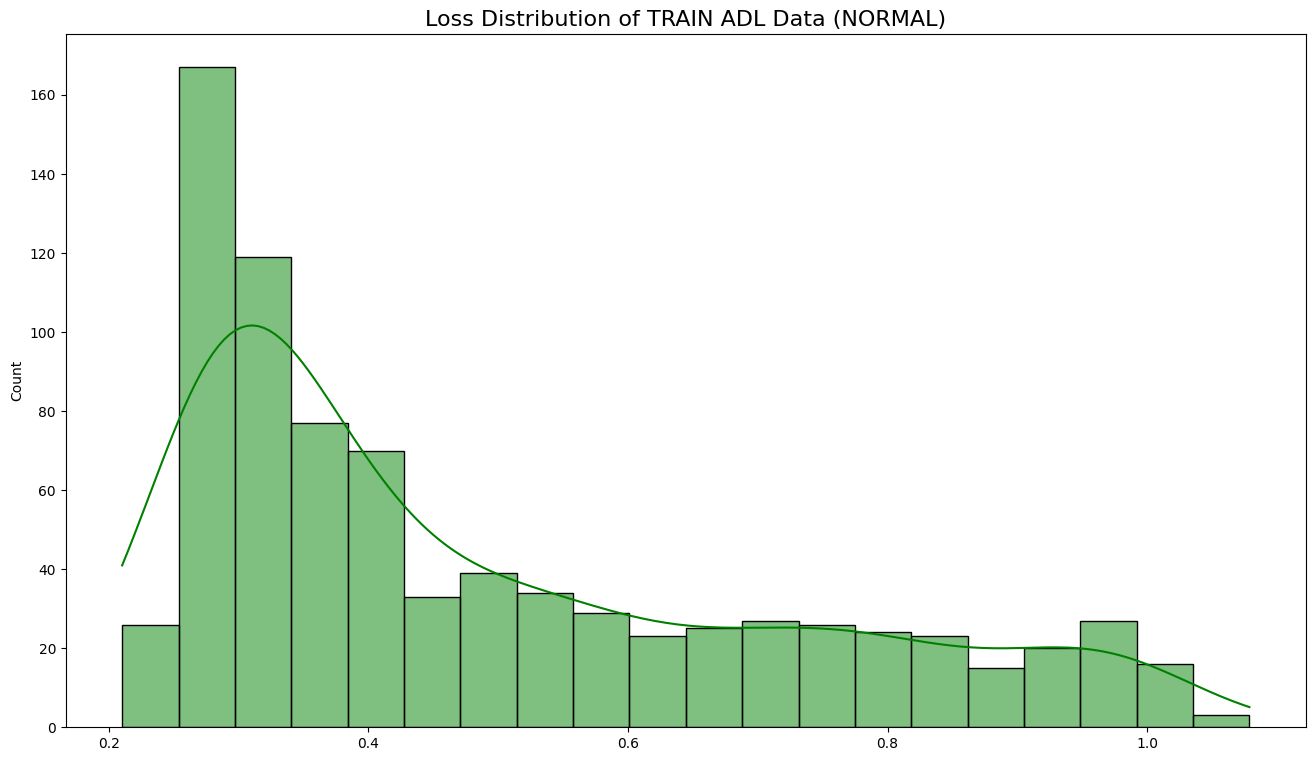

In [28]:
train_dataset = UMAFallDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

train_anomalies, train_scores, _ = detect_anomalies(model, ddpm, train_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TRAIN ADL Data (NORMAL)', fontsize=16)
sns.histplot(train_scores, bins=20, kde=True, color='green')
plt.show()

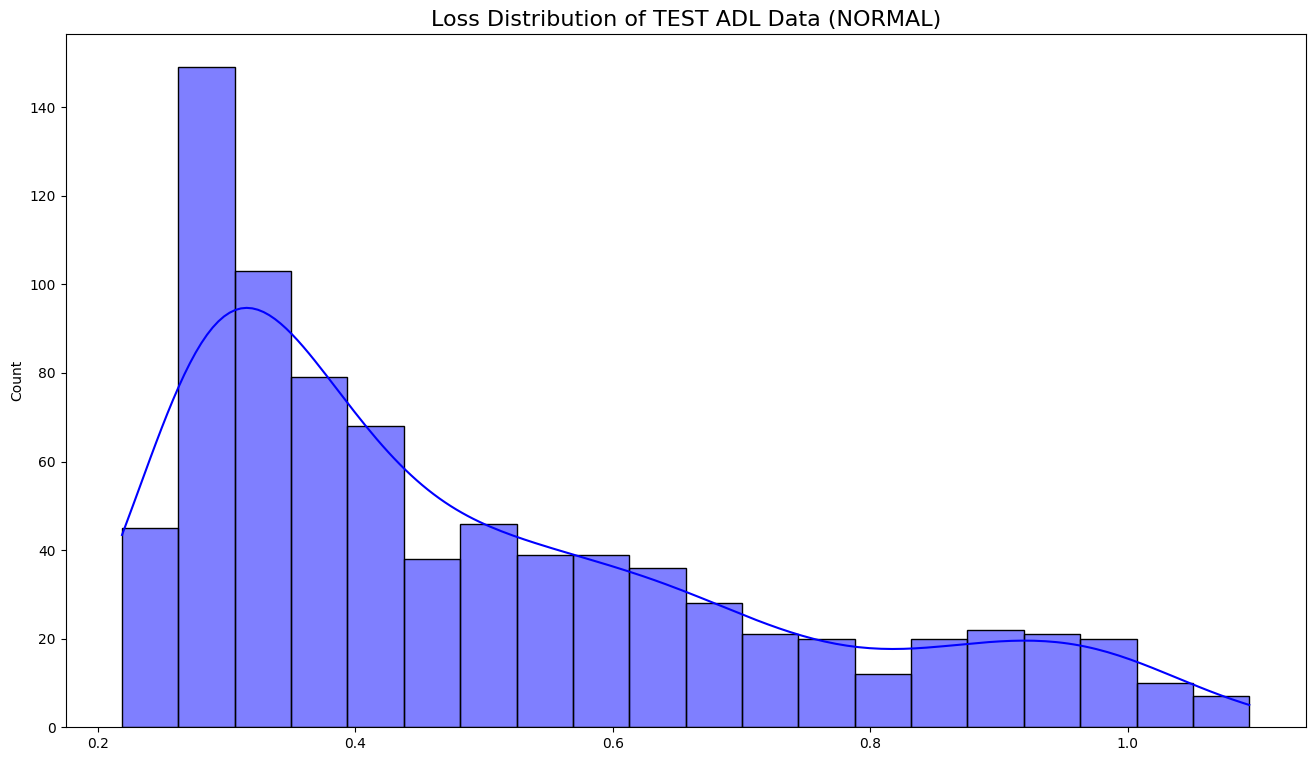

In [29]:
normal_anomalies, normal_scores, _ = detect_anomalies(model, ddpm, normal_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TEST ADL Data (NORMAL)', fontsize=16)
sns.histplot(normal_scores, bins=20, kde=True, color='blue')
plt.show()

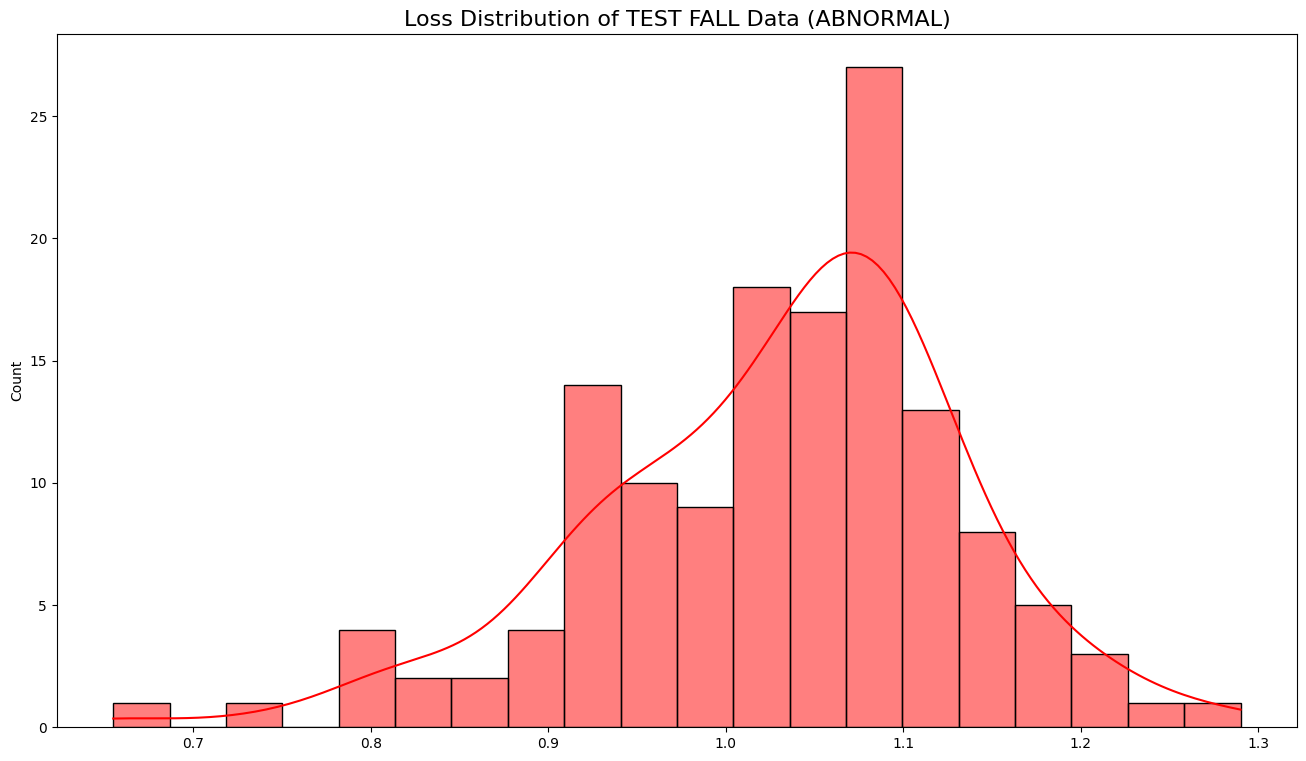

In [30]:
abnormal_anomalies, abnormal_scores, _ = detect_anomalies(model, ddpm, abnormal_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TEST FALL Data (ABNORMAL)', fontsize=16)
sns.histplot(abnormal_scores, bins=20, kde=True, color='red')
plt.show()

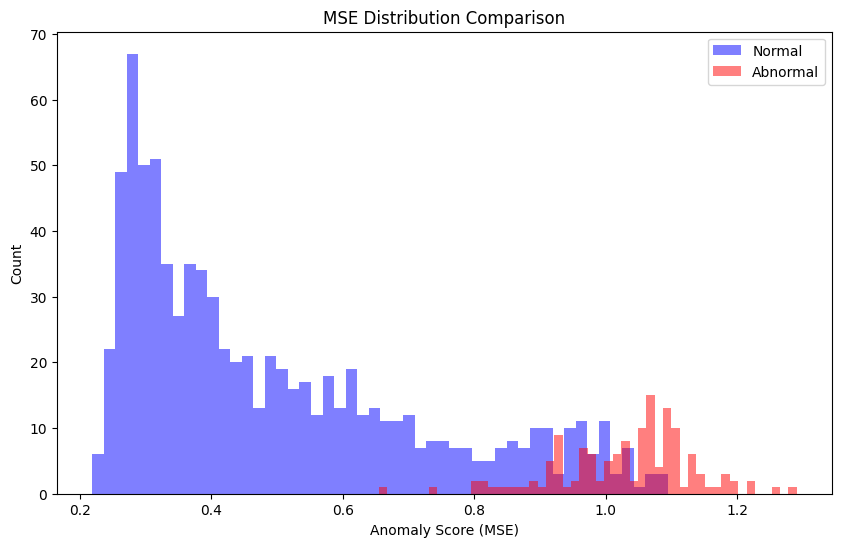

In [31]:
plt.figure(figsize=(10,6))
plt.title('MSE Distribution Comparison')
plt.hist(normal_scores, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores, bins=50, alpha=0.5, color='red', label='Abnormal')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()
plt.show()

In [32]:
error_df = pd.DataFrame({
    'reconstruction_error': np.concatenate([normal_scores, abnormal_scores]),
    'true_class': np.concatenate([np.zeros(len(normal_scores)), np.ones(len(abnormal_scores))])
})

print ("error dataframe head : ")
print(error_df.head(10))
print ()
print ("error dataframe tail : ")
print(error_df.tail(10))
print ()
print(error_df.describe())
print ()
error_df['true_class'].value_counts()

error dataframe head : 
   reconstruction_error  true_class
0              0.240456         0.0
1              0.913051         0.0
2              0.575315         0.0
3              0.265992         0.0
4              0.540802         0.0
5              0.989186         0.0
6              0.347916         0.0
7              0.570498         0.0
8              0.341519         0.0
9              0.377884         0.0

error dataframe tail : 
     reconstruction_error  true_class
953              1.101741         1.0
954              1.185486         1.0
955              0.996339         1.0
956              1.149662         1.0
957              1.155249         1.0
958              0.915441         1.0
959              1.053857         1.0
960              1.098997         1.0
961              1.066926         1.0
962              1.078210         1.0

       reconstruction_error  true_class
count            963.000000  963.000000
mean               0.570990    0.145379
std             

true_class
0.0    823
1.0    140
Name: count, dtype: int64

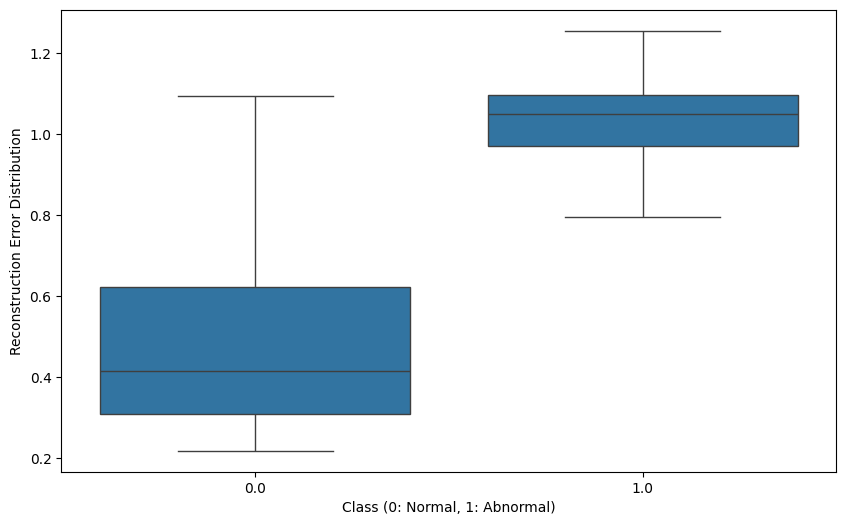

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df, showfliers=False)
plt.ylabel('Reconstruction Error Distribution')
plt.xlabel('Class (0: Normal, 1: Abnormal)')
plt.show()

In [34]:
# threshold = np.percentile(normal_scores, 90)
thresshold = 0.75

NameError: name 'threshold' is not defined

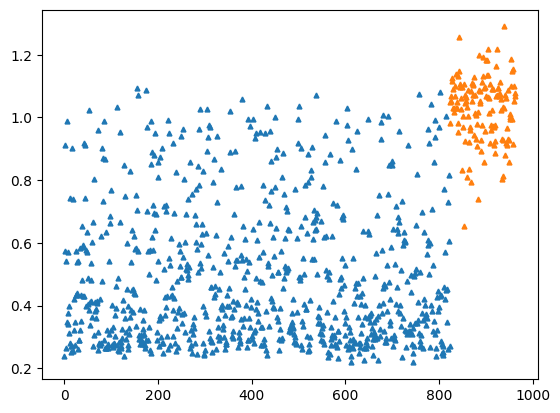

In [35]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label="Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()

In [ ]:
LABELS = ["Normal", "Abnormal"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(error_df.true_class, y_pred, average='binary')
accuracy = accuracy_score(error_df.true_class, y_pred)

print('\nPerformance Metrics:')
print(f'Accuracy Score : {accuracy:.4f}')
print(f'Precision     : {precision:.4f}')
print(f'Recall        : {recall:.4f}')
print(f'F1 Score      : {f1:.4f}')